# Importing Packages

In [1]:
import numpy as np
from scipy import linalg as splinalg
import matplotlib.pyplot as plt
from scipy import sparse as sp
import scipy.sparse.linalg as splin
from functools import reduce
import itertools
from scipy import linalg
from scipy.linalg import expm, logm
from scipy.special import comb
from itertools import combinations_with_replacement, product
from collections import Counter
import copy
from scipy.linalg import ishermitian
from scipy.linalg import eigh
import scipy

# Definitions

In [2]:
Z = sp.csc_matrix([[1, 0], [0, -1]])
X = sp.csc_matrix([[0, 1], [1, 0]])
Y = sp.csc_matrix([[0, -1j], [1j, 0]])
I = sp.csc_matrix([[1, 0], [0, 1]])

params={}
params['sites'] = 5
params['I'] = sp.eye(2)
params['X'] = X
params['Y'] = Y
params['Z'] = Z

In [3]:
print(params['Y'].toarray())

[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]


In [4]:
print(Y.toarray())

[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]


In [5]:
H = sp.csc_matrix((2**params['sites'], 2**params['sites']))
# H.toarray()

# Heisenberg Hamiltonian 1D

In [7]:
def generate_xyz_hamiltonian_uniform(N, Jx, Jy, Jz, params):
    """
    Returns: Generic XYZ model Hamiltonian
    """
    H = sp.csc_matrix((2**N, 2**N), dtype=complex)
    
    for i in range(N - 1):
        XX = reduce(sp.kron, (sp.eye(2**i), params['X'], params['X'], sp.eye(2**(N - 2 - i))))
        YY = reduce(sp.kron, (sp.eye(2**i), params['Y'], params['Y'], sp.eye(2**(N - 2 - i))))
        ZZ = reduce(sp.kron, (sp.eye(2**i), params['Z'], params['Z'], sp.eye(2**(N - 2 - i))))
        
        H += Jx * XX + Jy * YY + Jz * ZZ
    
    # ## Add periodic boundary condition term
    # XX = reduce(sp.kron, (params['X'], sp.eye(2**(N - 2)), params['X']))
    # YY = reduce(sp.kron, (params['Y'], sp.eye(2**(N - 2)), params['Y']))
    # ZZ = reduce(sp.kron, (params['Z'], sp.eye(2**(N - 2)), params['Z']))
    # H += Jx * XX + Jy * YY + Jz * ZZ
    
    return H

## Generate the Hamiltonian with periodic boundary conditions
Jx, Jy, Jz = 0.3, 0.4, 0.5

H = generate_xyz_hamiltonian_uniform(params['sites'], Jx, Jy, Jz, params)

print(H.toarray())

[[2. +0.j 0. +0.j 0. +0.j ... 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 1. +0.j 0.7+0.j ... 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0.7+0.j 0. +0.j ... 0. +0.j 0. +0.j 0. +0.j]
 ...
 [0. +0.j 0. +0.j 0. +0.j ... 0. +0.j 0.7+0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j ... 0.7+0.j 1. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j ... 0. +0.j 0. +0.j 2. +0.j]]


In [8]:
H.toarray()

array([[2. +0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 0. +0.j],
       [0. +0.j, 1. +0.j, 0.7+0.j, ..., 0. +0.j, 0. +0.j, 0. +0.j],
       [0. +0.j, 0.7+0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 0. +0.j],
       ...,
       [0. +0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 0.7+0.j, 0. +0.j],
       [0. +0.j, 0. +0.j, 0. +0.j, ..., 0.7+0.j, 1. +0.j, 0. +0.j],
       [0. +0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 2. +0.j]])

In [9]:
# eigenvalues, eigenvectors = splin.eigsh(H, k=1, which='SA')
eigenvalues, eigenvectors = np.linalg.eigh(H.toarray())

In [10]:
eigenvalues[0]

np.float64(-3.1080781902560304)

In [11]:
eigenvectors
print(eigenvectors[:,0])
ground_state = eigenvectors[:, 0]  

[-5.25139071e-19+0.j  1.80127078e-02+0.j -1.83278098e-02+0.j
 -6.41847686e-17+0.j  1.05520225e-02+0.j  5.53987657e-17+0.j
  2.77555756e-17+0.j  3.56878861e-02+0.j -1.83278098e-02+0.j
 -5.09521331e-17+0.j  2.59084666e-17+0.j -2.03981901e-01+0.j
 -5.03069808e-17+0.j  3.65261972e-01+0.j -1.65707647e-01+0.j
 -1.62607060e-17+0.j  1.80127078e-02+0.j  8.09770874e-18+0.j
  2.15559758e-17+0.j  2.10731593e-01+0.j -4.00110255e-17+0.j
 -7.27738347e-01+0.j  3.65261972e-01+0.j  1.32542721e-18+0.j
  6.41847686e-17+0.j  2.10731593e-01+0.j -2.03981901e-01+0.j
  4.77281611e-18+0.j  3.56878861e-02+0.j -9.95027538e-18+0.j
  1.58316783e-17+0.j  9.64822658e-03+0.j]


# Correlation matrix method

## One-site local operators

In [12]:
def generate_one_site_pauli_operators(N):
    one_site_ops = []
    for i in range(N - 1): 
        X_i = reduce(sp.kron, (sp.eye(2**i), params['X'], sp.eye(2**(N - i - 1))))
        Y_i = reduce(sp.kron, (sp.eye(2**i), params['Y'], sp.eye(2**(N - i - 1))))
        Z_i = reduce(sp.kron, (sp.eye(2**i), params['Z'], sp.eye(2**(N - i - 1))))
        one_site_ops.extend([X_i, Y_i, Z_i])
    return one_site_ops

one_site_operators = generate_one_site_pauli_operators(params['sites'])
# print(two_site_operators)

num_ops = len(one_site_operators)
# covariance_matrix = sp.csc_matrix((num_ops, num_ops), dtype=complex)
correlation_matrix = np.zeros((num_ops, num_ops), dtype=complex)

for i in range(num_ops):
    for j in range(num_ops):
        V_i = one_site_operators[i].toarray() 
        V_j = one_site_operators[j].toarray() 
        term1 = np.vdot(ground_state, np.dot(V_i, np.dot(V_j, ground_state)))
        term2 = np.vdot(ground_state, np.dot(V_i, ground_state)) * np.vdot(ground_state, np.dot(V_j, ground_state))
        # print(term1-term2)
        correlation_matrix[i, j] = term1 - term2  
        
# eigenvalues, eigenvectors = splin.eigsh(covariance_matrix)
eigenvalues1, eigenvectors1 = np.linalg.eigh(correlation_matrix)

## Eigenvectors with zero eigenvalue (local operators that commute with the ground state)
zero_eigenvectors1 = eigenvectors1[:, np.isclose(eigenvalues1, 0, atol=1e-8)]

print("Eigenvectors with zero eigenvalue of the covariance matrix (one-site Pauli operators):")
for i in range(zero_eigenvectors1.shape[1]):
    print(f"Eigenvector {i + 1}:")
    print(zero_eigenvectors1[:, i])

# # Reconstruct the effective Hamiltonian in the subspace of zero eigenvectors
# # Use the zero eigenvectors to construct an effective Hamiltonian
effective_hamiltonian_correl = np.zeros((2**params['sites'], 2**params['sites']), dtype=complex)
for i in range(zero_eigenvectors1.shape[1]):
    coeff = zero_eigenvectors1[:, i]
    V_eff = sum(coeff[j] * one_site_operators[j].toarray() for j in range(num_ops))
    effective_hamiltonian_correl += V_eff

print("\nEffective Hamiltonian in the subspace of zero eigenvectors:")
print(effective_hamiltonian_correl)

Eigenvectors with zero eigenvalue of the covariance matrix (one-site Pauli operators):

Effective Hamiltonian in the subspace of zero eigenvectors:
[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]


In [13]:
correlation_matrix.shape

(12, 12)

In [14]:
num_ops

12

In [15]:
eigenvalues1

array([1.47863696e-03, 7.28495299e-02, 7.33009340e-02, 1.21692271e-01,
       4.06278015e-01, 4.12038729e-01, 9.24886483e-01, 1.36464331e+00,
       1.46865792e+00, 1.47590181e+00, 2.12671785e+00, 2.42422647e+00])

In [16]:
(correlation_matrix==correlation_matrix.T.conj()).all()

np.False_

In [17]:
ishermitian(correlation_matrix)

False

## Two-site local operators

### For nearest neighbor interactions 

In [18]:
def generate_two_site_pauli_operators(N):
    two_site_ops = []
    Pauli_matrices = {'X': np.array([[0, 1], [1, 0]]),
                      'Y': np.array([[0, -1j], [1j, 0]]),
                      'Z': np.array([[1, 0], [0, -1]])}
    for i in range(N - 1):
        j = i + 1  
        for pauli1 in Pauli_matrices.values():
            for pauli2 in Pauli_matrices.values():
                op = reduce(sp.kron, (sp.eye(2**i), pauli1, sp.eye(2**(j - i - 1)), pauli2, sp.eye(2**(N - j - 1))))
                two_site_ops.append(op)

    
    return two_site_ops

two_site_operators = generate_two_site_pauli_operators(params['sites'])
# print(two_site_operators)

num_ops = len(two_site_operators)
# covariance_matrix = sp.csc_matrix((num_ops, num_ops), dtype=complex)
correlation_matrix = np.zeros((num_ops, num_ops), dtype=complex)

for i in range(num_ops):
    for j in range(num_ops):
        V_i = two_site_operators[i].toarray() 
        V_j = two_site_operators[j].toarray() 
        term1 = np.vdot(ground_state, np.dot(V_i, np.dot(V_j, ground_state)))
        term2 = np.vdot(ground_state, np.dot(V_i, ground_state)) * np.vdot(ground_state, np.dot(V_j, ground_state))
        # print(term1-term2)
        correlation_matrix[i, j] = term1 - term2  
        
# eigenvalues, eigenvectors = splin.eigsh(covariance_matrix)
eigenvalues1, eigenvectors1 = np.linalg.eigh(correlation_matrix)

## Eigenvectors with zero eigenvalue (local operators that commute with the ground state)
zero_eigenvectors1 = eigenvectors1[:, np.isclose(eigenvalues1, 0, atol=1e-15)]

print("Eigenvectors with zero eigenvalue of the correlation matrix (two-site Pauli operators):")
for i in range(zero_eigenvectors1.shape[1]):
    print(f"Eigenvector {i + 1}:")
    print(zero_eigenvectors1[:, i])

# # Reconstruct the effective Hamiltonian in the subspace of zero eigenvectors
# # Use the zero eigenvectors to construct an effective Hamiltonian
effective_hamiltonian_correl = np.zeros((2**params['sites'], 2**params['sites']), dtype=complex)
for i in range(zero_eigenvectors1.shape[1]):
    coeff = zero_eigenvectors1[:, i]
    V_eff = sum(coeff[j] * two_site_operators[j].toarray() for j in range(num_ops))
    effective_hamiltonian_correl += V_eff

print("\nEffective Hamiltonian in the subspace of zero eigenvectors:")
print(effective_hamiltonian_correl)

Eigenvectors with zero eigenvalue of the correlation matrix (two-site Pauli operators):
Eigenvector 1:
[ 0.        +0.j         -0.02292887-0.00319799j -0.05324842-0.02120382j
 -0.04564937-0.0220871j  -0.02715773+0.07442765j -0.02542714+0.05136785j
 -0.02544146+0.02529527j  0.01422474+0.02305175j  0.09218094-0.14787274j
 -0.25189912-0.14898707j -0.09321464+0.28857588j  0.00546737-0.03288273j
 -0.16687479+0.31022904j  0.35827629+0.09402382j -0.03851822-0.00087258j
  0.01280889-0.00749838j -0.00280648-0.0139802j  -0.04871296+0.09212334j
  0.25664671+0.14856044j  0.16687479-0.31022904j -0.01280889+0.00749838j
  0.09321464-0.28857588j -0.35194617-0.09459267j  0.00280648+0.0139802j
 -0.00546737+0.03288273j  0.03851822+0.00087258j  0.05662561-0.0928344j
  0.00474759-0.00042663j  0.04564937+0.0220871j   0.02544146-0.02529527j
  0.02292887+0.00319799j  0.03348786-0.07499649j -0.01422474-0.02305175j
  0.05324842+0.02120382j  0.02542714-0.05136785j -0.08426829+0.14716168j]
Eigenvector 2:
[ 0.   

In [19]:
correlation_matrix.shape

(36, 36)

In [20]:
num_ops

36

In [21]:
eigenvalues1
(correlation_matrix==correlation_matrix.T.conj()).all()

np.False_

In [22]:
ishermitian(correlation_matrix)

False

In [23]:
eigenvalues1

array([-5.09894773e-16, -1.86859908e-16,  6.36665543e-18,  1.54365265e-16,
        3.13962595e-16,  3.91360776e-16,  4.53668756e-15,  2.29630826e-06,
        1.71656813e-04,  1.74263412e-03,  2.60776659e-03,  1.90927267e-02,
        3.13708582e-02,  3.90443057e-02,  7.06741159e-02,  1.08343887e-01,
        1.62191439e-01,  1.73081196e-01,  2.01928717e-01,  2.09968656e-01,
        2.26475737e-01,  2.56334634e-01,  3.69814468e-01,  5.19001406e-01,
        8.74212486e-01,  1.07153658e+00,  1.34880261e+00,  2.06824327e+00,
        2.10821849e+00,  2.60371201e+00,  2.68527540e+00,  2.88871250e+00,
        2.98582081e+00,  3.02016636e+00,  3.32157618e+00,  3.52351256e+00])

In [24]:
num_ops

36

### For all types of two-site interactions

In [28]:
def generate_two_site_pauli_operators(N):
    two_site_ops = []
    Pauli_matrices = {'X': np.array([[0, 1], [1, 0]]),
                      'Y': np.array([[0, -1j], [1j, 0]]),
                      'Z': np.array([[1, 0], [0, -1]])}
    # For all possible combinations    
    for i in range(N - 1):
        for j in range(i+1, N):
            for pauli1 in Pauli_matrices.values():
                for pauli2 in Pauli_matrices.values():
                    op = reduce(sp.kron, (sp.eye(2**i), pauli1, sp.eye(2**(j - i - 1)), pauli2, sp.eye(2**(N - j - 1))))
                    two_site_ops.append(op)
    return two_site_ops

two_site_operators = generate_two_site_pauli_operators(params['sites'])
# print(two_site_operators)

num_ops = len(two_site_operators)
# covariance_matrix = sp.csc_matrix((num_ops, num_ops), dtype=complex)
correlation_matrix = np.zeros((num_ops, num_ops), dtype=complex)

for i in range(num_ops):
    for j in range(num_ops):
        V_i = two_site_operators[i].toarray() 
        V_j = two_site_operators[j].toarray() 
        term1 = np.vdot(ground_state, np.dot(V_i, np.dot(V_j, ground_state)))
        term2 = np.vdot(ground_state, np.dot(V_i, ground_state)) * np.vdot(ground_state, np.dot(V_j, ground_state))
        # print(term1-term2)
        correlation_matrix[i, j] = term1 - term2  
        
# eigenvalues, eigenvectors = splin.eigsh(covariance_matrix)
eigenvalues1, eigenvectors1 = np.linalg.eigh(correlation_matrix)

## Eigenvectors with zero eigenvalue (local operators that commute with the ground state)
zero_eigenvectors1 = eigenvectors1[:, np.isclose(eigenvalues1, 0, atol=1e-15)]

print("Eigenvectors with zero eigenvalue of the correlation matrix (two-site Pauli operators):")
for i in range(zero_eigenvectors1.shape[1]):
    print(f"Eigenvector {i + 1}:")
    print(zero_eigenvectors1[:, i])

# # Reconstruct the effective Hamiltonian in the subspace of zero eigenvectors
# # Use the zero eigenvectors to construct an effective Hamiltonian
effective_hamiltonian_correl = np.zeros((2**params['sites'], 2**params['sites']), dtype=complex)
for i in range(zero_eigenvectors1.shape[1]):
    coeff = zero_eigenvectors1[:, i]
    V_eff = sum(coeff[j] * two_site_operators[j].toarray() for j in range(num_ops))
    effective_hamiltonian_correl += V_eff

print("\nEffective Hamiltonian in the subspace of zero eigenvectors:")
print(effective_hamiltonian_correl)

Eigenvectors with zero eigenvalue of the correlation matrix (two-site Pauli operators):
Eigenvector 1:
[ 0.00000000e+00+0.j          3.23147375e-02-0.01186816j
  3.04644880e-02-0.14020954j  6.94154054e-03+0.05748659j
 -2.57055591e-02-0.01715339j -2.30903630e-02+0.0477561j
  3.74639552e-03-0.05139583j  1.54878887e-01+0.03468401j
 -1.58564465e-01+0.06356387j -5.26472473e-02+0.01100084j
 -2.29155150e-02-0.11643924j  8.08264802e-03+0.01585255j
 -1.25747033e-02+0.03466435j -2.65836771e-02+0.01845976j
 -3.26121548e-03+0.0567219j   9.10274334e-02+0.0177229j
  1.54591074e-01-0.02956934j -6.07214339e-02+0.02465859j
 -4.26211016e-02+0.01542532j -4.83901796e-03-0.17080901j
  1.60036617e-02-0.00048162j -7.73739529e-04+0.09451554j
 -2.21354297e-01-0.09820137j -2.10678331e-02+0.01500825j
 -7.92545957e-02-0.180667j    2.99826970e-02+0.01600373j
  1.46855465e-01+0.05530987j  9.32898759e-02+0.01030649j
 -3.75067111e-02+0.05560133j -3.76343825e-02+0.03367111j
 -8.36019719e-03+0.08490359j  1.55922865e-01

In [29]:
correlation_matrix.shape

(90, 90)

In [30]:
num_ops

90

In [31]:
eigenvalues1
(correlation_matrix==correlation_matrix.T.conj()).all()

np.False_

In [32]:
ishermitian(correlation_matrix)

False

In [33]:
eigenvalues1

array([-1.16691817e-15, -1.09482318e-15, -9.63095135e-16, -9.40143110e-16,
       -8.74641611e-16, -7.53625151e-16, -7.41242121e-16, -7.11990976e-16,
       -6.64717892e-16, -6.58827799e-16, -6.17098003e-16, -5.34486810e-16,
       -5.20862981e-16, -5.06476611e-16, -4.67145636e-16, -4.37797187e-16,
       -4.28767589e-16, -3.58785115e-16, -3.33634009e-16, -3.22618777e-16,
       -3.06729597e-16, -2.65799102e-16, -2.54707803e-16, -2.06640280e-16,
       -1.93240657e-16, -1.67312808e-16, -1.56873832e-16, -1.25118079e-16,
       -1.04000992e-16, -6.48927453e-17, -4.45752293e-17, -2.70051109e-17,
        2.03052628e-17,  4.38302593e-17,  5.96512264e-17,  7.97493647e-17,
        8.12489805e-17,  8.69898987e-17,  9.79487178e-17,  1.35072838e-16,
        1.57315948e-16,  2.42529782e-16,  2.61030179e-16,  2.66124446e-16,
        3.01380747e-16,  3.47798793e-16,  3.63611902e-16,  4.13709676e-16,
        4.26624765e-16,  4.82584274e-16,  5.63443494e-16,  5.67480458e-16,
        5.93259932e-16,  

In [34]:
num_ops

90

# One-site + two-site local interactions

In [35]:
def generate_one_and_two_site_pauli_operators(N, params):
    """
    Returns: one-site and two-site (with only nearest neighbor interactions) local operators
    """
    operators = []
    Pauli_matrices = {'X': params['X'], 'Y': params['Y'], 'Z': params['Z']}

    ## One-site local operators
    for i in range(N):
        for pauli in Pauli_matrices.values():
            op = reduce(sp.kron, (sp.eye(2**i), pauli, sp.eye(2**(N - i - 1))))
            operators.append(op)
    
    ## Two-site local operators - nearest neighbor interactions
    for i in range(N - 1):
        j = i + 1  
        for pauli1 in Pauli_matrices.values():
            for pauli2 in Pauli_matrices.values():
                op = reduce(sp.kron, (sp.eye(2**i), pauli1, sp.eye(2**(j - i - 1)), pauli2, sp.eye(2**(N - j - 1))))
                operators.append(op)
    
    return operators

all_operators = generate_one_and_two_site_pauli_operators(params['sites'], params)

In [36]:
num_ops = len(all_operators)
# covariance_matrix = sp.csc_matrix((num_ops, num_ops), dtype=complex)
correlation_matrix = np.zeros((num_ops, num_ops), dtype=complex)

for i in range(num_ops):
    for j in range(num_ops):
        V_i = all_operators[i].toarray() 
        V_j = all_operators[j].toarray() 
        term1 = np.vdot(ground_state, np.dot(V_i, np.dot(V_j, ground_state)))
        term2 = np.vdot(ground_state, np.dot(V_i, ground_state)) * np.vdot(ground_state, np.dot(V_j, ground_state))
        # print(term1-term2)
        correlation_matrix[i, j] = term1 - term2  
        
# eigenvalues, eigenvectors = splin.eigsh(covariance_matrix)
eigenvalues1, eigenvectors1 = np.linalg.eigh(correlation_matrix)

## Eigenvectors with zero eigenvalue (local operators that commute with the ground state)
zero_eigenvectors1 = eigenvectors1[:, np.isclose(eigenvalues1, 0, atol=1e-15)]

print("Eigenvectors with zero eigenvalue of the correlation matrix:")
for i in range(zero_eigenvectors1.shape[1]):
    print(f"Eigenvector {i + 1}:")
    print(zero_eigenvectors1[:, i])

# # Reconstruct the effective Hamiltonian in the subspace of zero eigenvectors
# # Use the zero eigenvectors to construct an effective Hamiltonian
effective_hamiltonian_correl = np.zeros((2**params['sites'], 2**params['sites']), dtype=complex)
for i in range(zero_eigenvectors1.shape[1]):
    coeff = zero_eigenvectors1[:, i]
    V_eff = sum(coeff[j] * all_operators[j].toarray() for j in range(num_ops))
    effective_hamiltonian_correl += V_eff

print("\nEffective Hamiltonian in the subspace of zero eigenvectors:")
print(effective_hamiltonian_correl)

Eigenvectors with zero eigenvalue of the correlation matrix:
Eigenvector 1:
[ 0.00000000e+00+0.j         -3.13977170e-02-0.03192404j
 -7.31664660e-02-0.13635888j -5.52110942e-02-0.12414759j
 -4.83227922e-02+0.10883853j  6.27078028e-02-0.0096303j
  9.43315010e-02-0.11277489j -9.46128595e-02-0.06194118j
 -1.08968803e-01+0.02464471j -2.33649424e-02-0.01013689j
 -2.35635642e-02+0.00069631j -2.19856268e-01-0.09105817j
 -4.08077453e-02+0.12723582j  1.50108852e-01+0.076677j
  1.70642315e-01+0.23590215j  2.47374231e-01-0.2093877j
 -1.99652541e-01-0.06594214j  1.35841805e-01+0.00988282j
 -1.40225806e-01-0.25859666j -7.66946882e-02+0.10377422j
  5.09771372e-02-0.10276595j  3.41609274e-02+0.04635317j
 -1.80619765e-02-0.07184017j -6.72302426e-02-0.10165317j
  2.10319249e-02+0.01263524j  1.96088814e-02-0.01848993j
 -1.06586823e-01-0.05865862j  3.83838192e-02-0.02251669j
 -1.56068080e-02-0.04472725j -7.18898215e-02+0.12664894j
 -5.73464446e-04-0.03969959j -2.47783849e-02+0.00125575j
  4.88901490e-02

# First excitation gap of the correlation matrix as a function of energy eigenvalues of the generic XYZ model

First excitation gap of the correlation matrix for the ground state: 5.442787451085761e-16


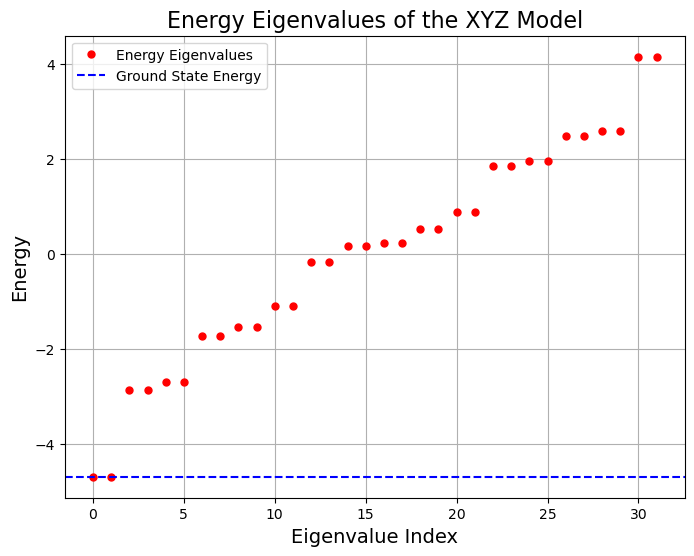

In [40]:
from functools import reduce
import scipy.sparse as sp
import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh
import matplotlib.pyplot as plt

def generate_xyz_hamiltonian(N, Jx, Jy, Jz, params):
    """
    Generate the Hamiltonian for the XYZ model with uniform but distinct couplings.
    
    Args:
        N (int): Number of sites in the system.
        Jx (float): Coupling constant for X_i X_{i+1} terms.
        Jy (float): Coupling constant for Y_i Y_{i+1} terms.
        Jz (float): Coupling constant for Z_i Z_{i+1} terms.
        params (dict): Dictionary containing Pauli matrices ('X', 'Y', 'Z') and identity ('I').
    
    Returns:
        scipy.sparse.csc_matrix: Hamiltonian of the XYZ model as a sparse matrix.
    """
    H = sp.csc_matrix((2**N, 2**N), dtype=complex)
    for i in range(N - 1):
        XX = reduce(sp.kron, (sp.eye(2**i), params['X'], params['X'], sp.eye(2**(N - 2 - i))))
        YY = reduce(sp.kron, (sp.eye(2**i), params['Y'], params['Y'], sp.eye(2**(N - 2 - i))))
        ZZ = reduce(sp.kron, (sp.eye(2**i), params['Z'], params['Z'], sp.eye(2**(N - 2 - i))))
        H += Jx * XX + Jy * YY + Jz * ZZ
    return H

def generate_pauli_operators(N, params):
    """
    Generate all one-site and two-site (nearest-neighbor) Pauli operators.
    
    Args:
        N (int): Number of sites in the system.
        params (dict): Dictionary containing Pauli matrices ('X', 'Y', 'Z') and identity ('I').
    
    Returns:
        list: List of all Pauli operators as sparse matrices.
    """
    operators = []
    Pauli_matrices = {'X': params['X'], 'Y': params['Y'], 'Z': params['Z']}
    
    # One-site operators
    for i in range(N):
        for pauli in Pauli_matrices.values():
            op = reduce(sp.kron, (sp.eye(2**i), pauli, sp.eye(2**(N - i - 1))))
            operators.append(op)
    
    # Two-site (nearest-neighbor) operators
    for i in range(N - 1):
        j = i + 1  # Nearest neighbor
        for pauli1 in Pauli_matrices.values():
            for pauli2 in Pauli_matrices.values():
                op = reduce(sp.kron, (sp.eye(2**i), pauli1, sp.eye(2**(j - i - 1)), pauli2, sp.eye(2**(N - j - 1))))
                operators.append(op)
    
    return operators

def compute_correlation_matrix(ground_state, operators):
    """
    Compute the correlation matrix using the ground state and Pauli operators.
    
    Args:
        ground_state (numpy.ndarray): Ground state wavefunction.
        operators (list): List of Pauli operators as sparse matrices.
    
    Returns:
        numpy.ndarray: Correlation matrix.
    """
    num_ops = len(operators)
    correlation_matrix = np.zeros((num_ops, num_ops), dtype=complex)
    
    for i in range(num_ops):
        for j in range(num_ops):
            V_i = operators[i].toarray()
            V_j = operators[j].toarray()
            term1 = np.vdot(ground_state, np.dot(V_i, np.dot(V_j, ground_state)))
            term2 = np.vdot(ground_state, np.dot(V_i, ground_state)) * np.vdot(ground_state, np.dot(V_j, ground_state))
            correlation_matrix[i, j] = term1 - term2
    
    return correlation_matrix

def first_excitation_gap(correlation_matrix):
    """
    Compute the first excitation gap of the correlation matrix.
    
    Args:
        correlation_matrix (numpy.ndarray): Correlation matrix.
    
    Returns:
        float: First excitation gap.
    """
    eigenvalues = np.linalg.eigvalsh(correlation_matrix)
    # zero_eigenvalues = eigenvalues[np.isclose(eigenvalues, 0, atol=1e-8)]
    # non_zero_eigenvalues = eigenvalues[~np.isclose(eigenvalues, 0, atol=1e-8)]
    
    # if len(non_zero_eigenvalues) == 0:
    #     return 0.0  # No gap if all eigenvalues are zero
    # else:
    #     return np.min(non_zero_eigenvalues) - np.max(zero_eigenvalues)
    return eigenvalues[1] - eigenvalues[0]

# Parameters
params = {
    'sites': 5,
    'I': sp.eye(2),
    'X': sp.csc_matrix([[0, 1], [1, 0]]),
    'Y': sp.csc_matrix([[0, -1j], [1j, 0]]),
    'Z': sp.csc_matrix([[1, 0], [0, -1]])
}

# Coupling constants
Jx = 1.0
Jy = 0.5
Jz = 0.2

# Generate Hamiltonian
H = generate_xyz_hamiltonian(params['sites'], Jx, Jy, Jz, params)

# Compute all eigenvalues and eigenvectors of the Hamiltonian
eigenvalues, eigenvectors = eigh(H.toarray())

# Generate Pauli operators
operators = generate_pauli_operators(params['sites'], params)

# Compute first excitation gap for the ground state (lowest energy eigenstate)
ground_state = eigenvectors[:, 0]  # Ground state is the eigenvector with the lowest eigenvalue
correlation_matrix = compute_correlation_matrix(ground_state, operators)
gap = first_excitation_gap(correlation_matrix)

print(f"First excitation gap of the correlation matrix for the ground state: {gap}")

# Plot energy eigenvalues
plt.figure(figsize=(8, 6))
plt.plot(eigenvalues, 'ro', markersize=5, label='Energy Eigenvalues')
plt.axhline(y=eigenvalues[0], color='b', linestyle='--', label='Ground State Energy')
plt.xlabel('Eigenvalue Index', fontsize=14)
plt.ylabel('Energy', fontsize=14)
plt.title('Energy Eigenvalues of the XYZ Model', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()